In [1]:
# Libraries

import json
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Zrimec2020r

from source.python.cnn import core     as cnn_core
from source.python.cnn import dataset  as cnn_dataset
from source.python.cnn import model    as cnn_model
from source.python.cnn import mutation as cnn_mutation
from source.python.cnn import plot     as cnn_plot
from source.python.cnn import util     as cnn_util
from source.python.io  import loader   as data_loader
from source.python.io  import writer   as data_writer

# 1. Setup

In [4]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp07-zrimec2020', 'regression')
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP02 = os.path.join(OUT,      'nbp02-anndata')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature')
RES_NBP05 = os.path.join(OUT,      'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\regression
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\regression\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\regression\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target


In [5]:
# System and device

DEVICE = cnn_core.get_device(only_cpu = False)
SYSTEM = cnn_core.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 22.432 GB


In [6]:
# Load the input transcript features

mutation_feature_sequence = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'mutation-features-bp2150.fasta'),
	to_string = True
)

mutation_feature_base = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-base.npz')
)

feature_sequence = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

feature_base = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base.npz')
)

# 2. Config

In [7]:
# Define output and inputs

TARGET_GROUP   = 'tissue'
TARGET_TYPE    = 'mean'
TARGET_SIZE    = None
INPUT_FEATURES = None

In [8]:
# Load features

dataframe, target_value, target_order = data_loader.load_feature_targets(
	group    = f'{TARGET_GROUP}-{TARGET_TYPE}',
	explode  = True,
	filters  = {
		'tissue'       : None,
		'group'        : None,
		'age'          : None,
		'perturbation' : None
	},
	directory = RES_NBP05,
	filename  = f'mapping-{TARGET_TYPE}-grouped.pkl'
)

if 'Feature' in dataframe.columns :
	feature_base = {
		key : numpy.concatenate((feature_base[key.split('?')[-1]], value))
		for key, value in dataframe['Feature'].to_dict().items()
	}

TARGET_SIZE   = len(target_order)
INPUT_FEATURE = len(list(feature_base.values())[0])

dataframe

,Transcript,TPM_Value,TPM_Label,Tissue,Feature
flower?AT1G01010.1,AT1G01010.1,[1.5681916074727578],[1],[flower],"[1, 0, 0, 0, 0]"
leaf?AT1G01010.1,AT1G01010.1,[1.301200815779489],[1],[leaf],"[0, 1, 0, 0, 0]"
root?AT1G01010.1,AT1G01010.1,[2.2188703135217023],[2],[root],"[0, 0, 1, 0, 0]"
seed?AT1G01010.1,AT1G01010.1,[1.4635188472678688],[1],[seed],"[0, 0, 0, 1, 0]"
seedling?AT1G01010.1,AT1G01010.1,[1.7152924597435606],[1],[seedling],"[0, 0, 0, 0, 1]"
...,...,...,...,...,...
flower?AT5G67640.1,AT5G67640.1,[2.00921777463083],[2],[flower],"[1, 0, 0, 0, 0]"
leaf?AT5G67640.1,AT5G67640.1,[1.6061456372803276],[1],[leaf],"[0, 1, 0, 0, 0]"
root?AT5G67640.1,AT5G67640.1,[1.819972849820015],[1],[root],"[0, 0, 1, 0, 0]"
seed?AT5G67640.1,AT5G67640.1,[1.8406892672654074],[1],[seed],"[0, 0, 0, 1, 0]"


In [9]:
# Single global config

CONFIG = {
	'core/random'                  : None,
	'core/verbose'                 : False,
	'core/device'                  : DEVICE,
	'core/rootdir'                 : ROOT,
	'dataset/expanddim'            : None,
	'dataset/batch/train'          : 32,
	'dataset/batch/valid'          : 32,
	'dataset/batch/test'           : 32,
	'dataset/split/valid'          : 0.2,
	'dataset/split/test'           : 0.2,
	'criterion/name'               : 'mse',
	'criterion/reduction'          : 'mean',
	'optimizer/name'               : 'adam',
	'optimizer/lr'                 : 3.262648825129617e-05,
	'optimizer/decay'              : 0.05530820765433695,
	'optimizer/momentum'           : 0.5857655085105684,
	'scheduler/name'               : 'constant',
	'scheduler/plateau/factor'     : 0.3798409889797759,
	'scheduler/plateau/patience'   : 4,
	'scheduler/linear/factor'      : 0.04318109387491916,
	'scheduler/step/factor'        : 0.16975929027771253,
	'scheduler/step/patience'      : 11,
	'scheduler/exponential/factor' : 0.9652544464799763,
	'model/input/channels'         : 1,
	'model/input/height'           : 4,
	'model/input/width'            : 2150,
	'model/input/features'         : INPUT_FEATURE,
	'model/epochs'                 : 10,
	'model/dropout'                : 0.02,
	'model/leakyrelu'              : 0.0,
	'model/conv1/filters'          : 32,
	'model/conv1/kernel'           : 11,
	'model/conv1/padding'          : 'none',
	'model/conv1/dilation'         : 1,
	'model/conv2/filters'          : 32,
	'model/conv2/kernel'           : 31,
	'model/conv2/padding'          : 'none',
	'model/conv2/dilation'         : 1,
	'model/conv3/filters'          : 64,
	'model/conv3/kernel'           : 41,
	'model/conv3/padding'          : 'none',
	'model/conv3/dilation'         : 1,
	'model/maxpool1/kernel'        : 5,
	'model/maxpool1/stride'        : 5,
	'model/maxpool1/padding'       : 'same',
	'model/maxpool2/kernel'        : 3,
	'model/maxpool2/stride'        : 3,
	'model/maxpool2/padding'       : 'same',
	'model/maxpool3/kernel'        : 3,
	'model/maxpool3/stride'        : 3,
	'model/maxpool3/padding'       : 'same',
	'model/fc1/features'           : 64,
	'model/fc2/features'           : 512,
	'model/fc3/features'           : TARGET_SIZE,
	'model/output/target'          : TARGET_GROUP,
	'model/output/type'            : TARGET_TYPE,
	'model/output/size'            : TARGET_SIZE
}

CONFIG['core/random'] = cnn_core.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

In [10]:
# Prints

print('Input Feature : {}'.format(CONFIG['model/input/features']))
print('Output Target : {}'.format(CONFIG['model/output/target']))
print('Output Type   : {}'.format(CONFIG['model/output/type']))
print('Output Size   : {}'.format(CONFIG['model/output/size']))
print('Random Seed   : {}'.format(CONFIG['core/random']))

Input Feature : 77
Output Target : tissue
Output Type   : mean
Output Size   : 1
Random Seed   : 815242843


# 3. Dataloaders

## 3.1 Normal

In [11]:
# Create dataset

dataset = cnn_dataset.to_dataset(
	sequences   = feature_sequence,
	features    = feature_base,
	targets     = target_value,
	expand_dims = CONFIG['dataset/expanddim']
)

In [12]:
# Create dataloader

dataloaders = cnn_dataset.to_dataloaders(
	dataset     = dataset,
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : CONFIG['dataset/split/valid'],
		'test'  : CONFIG['dataset/split/test']
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [13]:
# Display train dataloader

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [14]:
# Display valid dataloader

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [15]:
# Display test dataloader

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	verbose    = CONFIG['core/verbose']
)

## 3.2 Mutation

In [16]:
# Update mutation features

if 'Feature' in dataframe.columns :
	mutation_feature_base_new = dict()

	for x in mutation_feature_base.keys() :
		df = dataframe.loc[dataframe['Transcript'] == x.split('-')[0]]

		for index, row in df.iterrows() :
			key = index + '-' + x.split('-')[-1]
			val = numpy.concatenate((mutation_feature_base[x], row['Feature']))

			mutation_feature_base_new[key] = val

	mutation_feature_base = mutation_feature_base_new

In [17]:
# Create mutation dataloader

mutation_dataloader = cnn_mutation.create_dataloader(
	sequences   = mutation_feature_sequence,
	features    = mutation_feature_base,
	targets     = target_value,
	expand_dims = CONFIG['dataset/expanddim'],
	random_seed = CONFIG['core/random']
)

In [18]:
# Display mutation dataloader

cnn_dataset.show_dataloader(
	dataloader = mutation_dataloader,
	verbose    = CONFIG['core/verbose']
)

# 4. Model

## 4.1 Structure

In [19]:
# Create and display the model structure

model = Zrimec2020r(params = CONFIG)

model.summary(
	batch_size  = CONFIG['dataset/batch/train'],
	in_height   = CONFIG['model/input/height'],
	in_width    = CONFIG['model/input/width'],
	in_features = CONFIG['model/input/features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020r                              [32, 4, 2150]             [32, 1]                   --
├─Zrimec2020: 1-1                        [32, 4, 2150]             [32, 512]                 --
│    └─Conv1d: 2-1                       [32, 4, 2150]             [32, 32, 2140]            1,440
│    └─LeakyReLU: 2-2                    [32, 32, 2140]            [32, 32, 2140]            --
│    └─BatchNorm1d: 2-3                  [32, 32, 2140]            [32, 32, 2140]            64
│    └─Dropout: 2-4                      [32, 32, 2140]            [32, 32, 2140]            --
│    └─MaxPool1d: 2-5                    [32, 32, 2140]            [32, 32, 428]             --
│    └─Conv1d: 2-6                       [32, 32, 428]             [32, 32, 398]             31,776
│    └─LeakyReLU: 2-7                    [32, 32, 398]             [32, 32, 398]             --
│    └─BatchNorm1d: 2-8     

In [20]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Metrics

In [21]:
# Define metrics

METRICS = {
	'mse' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
	'mae' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
	'r2'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2', output_size = CONFIG['model/output/size'])
}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

## 4.3 Parameters

In [22]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG,
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader
}

## 4.4 Training

In [23]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = model_params
)

## 4.5 Visualization

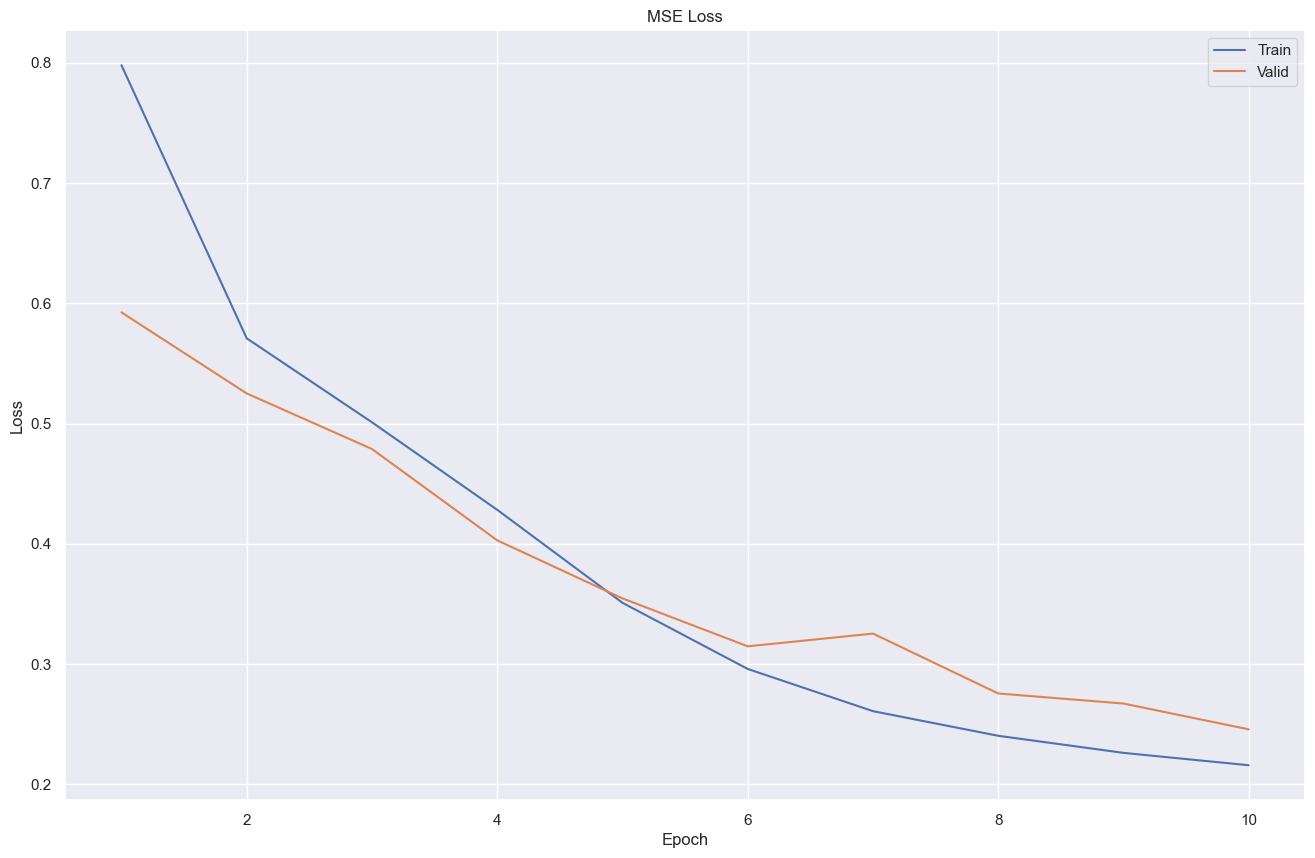

In [24]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'MSE Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

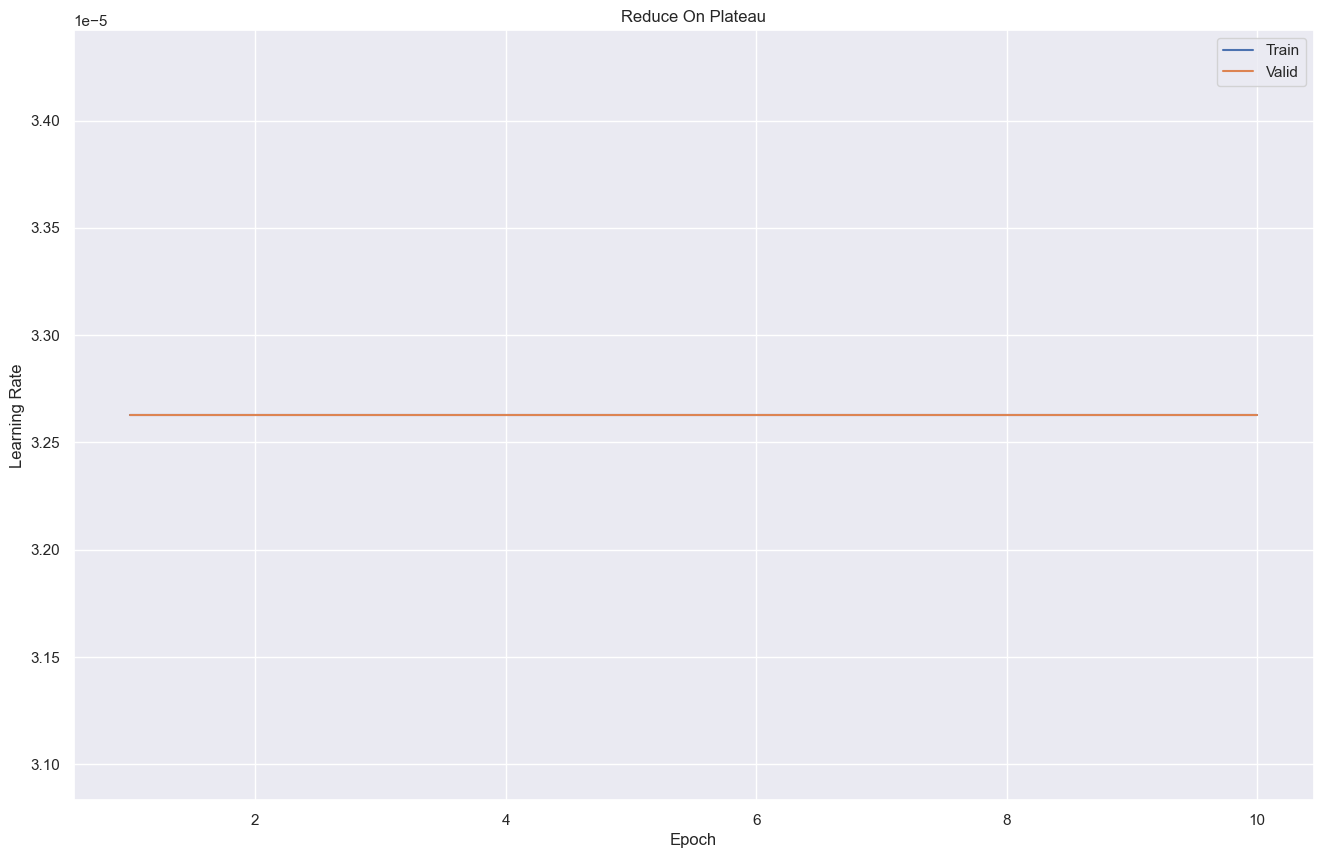

In [25]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

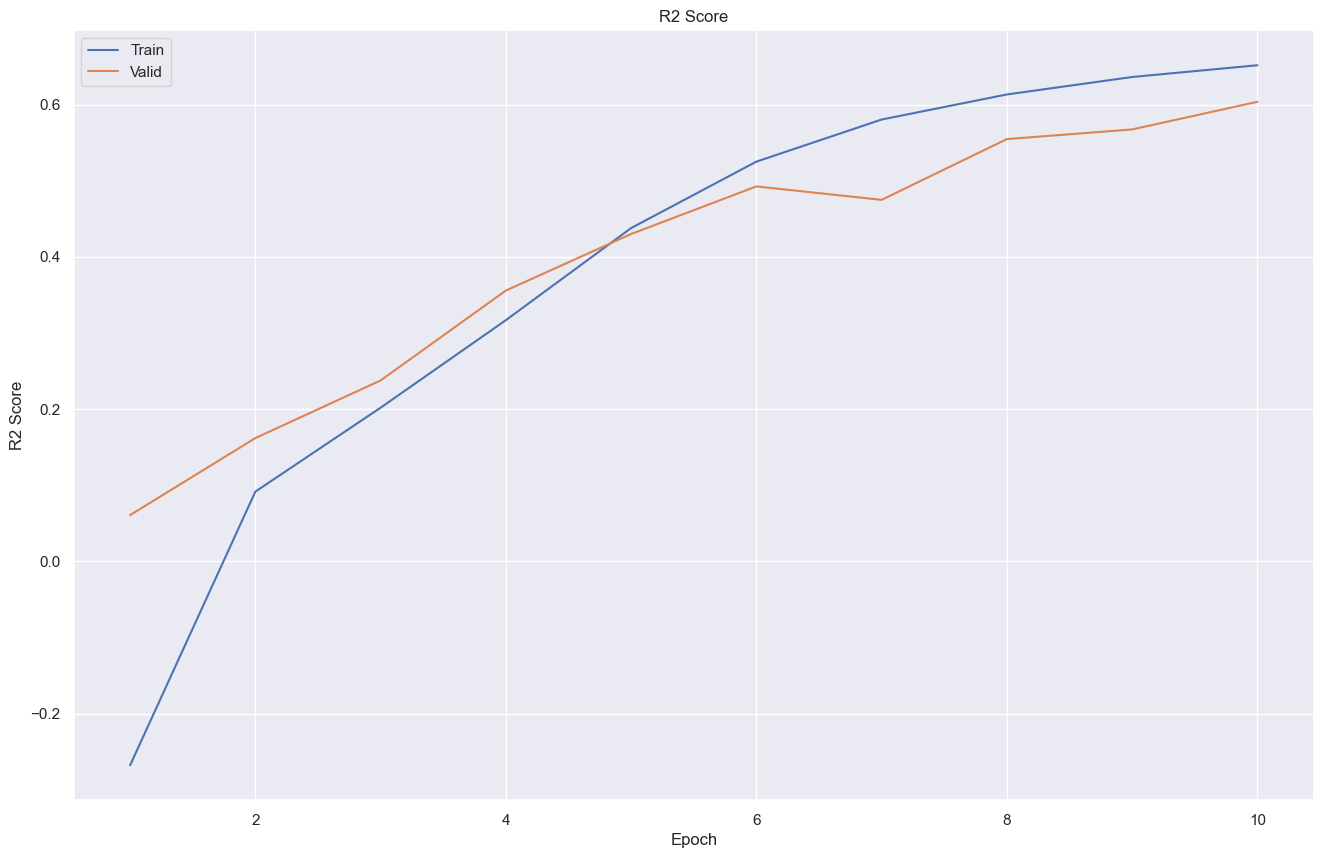

In [26]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

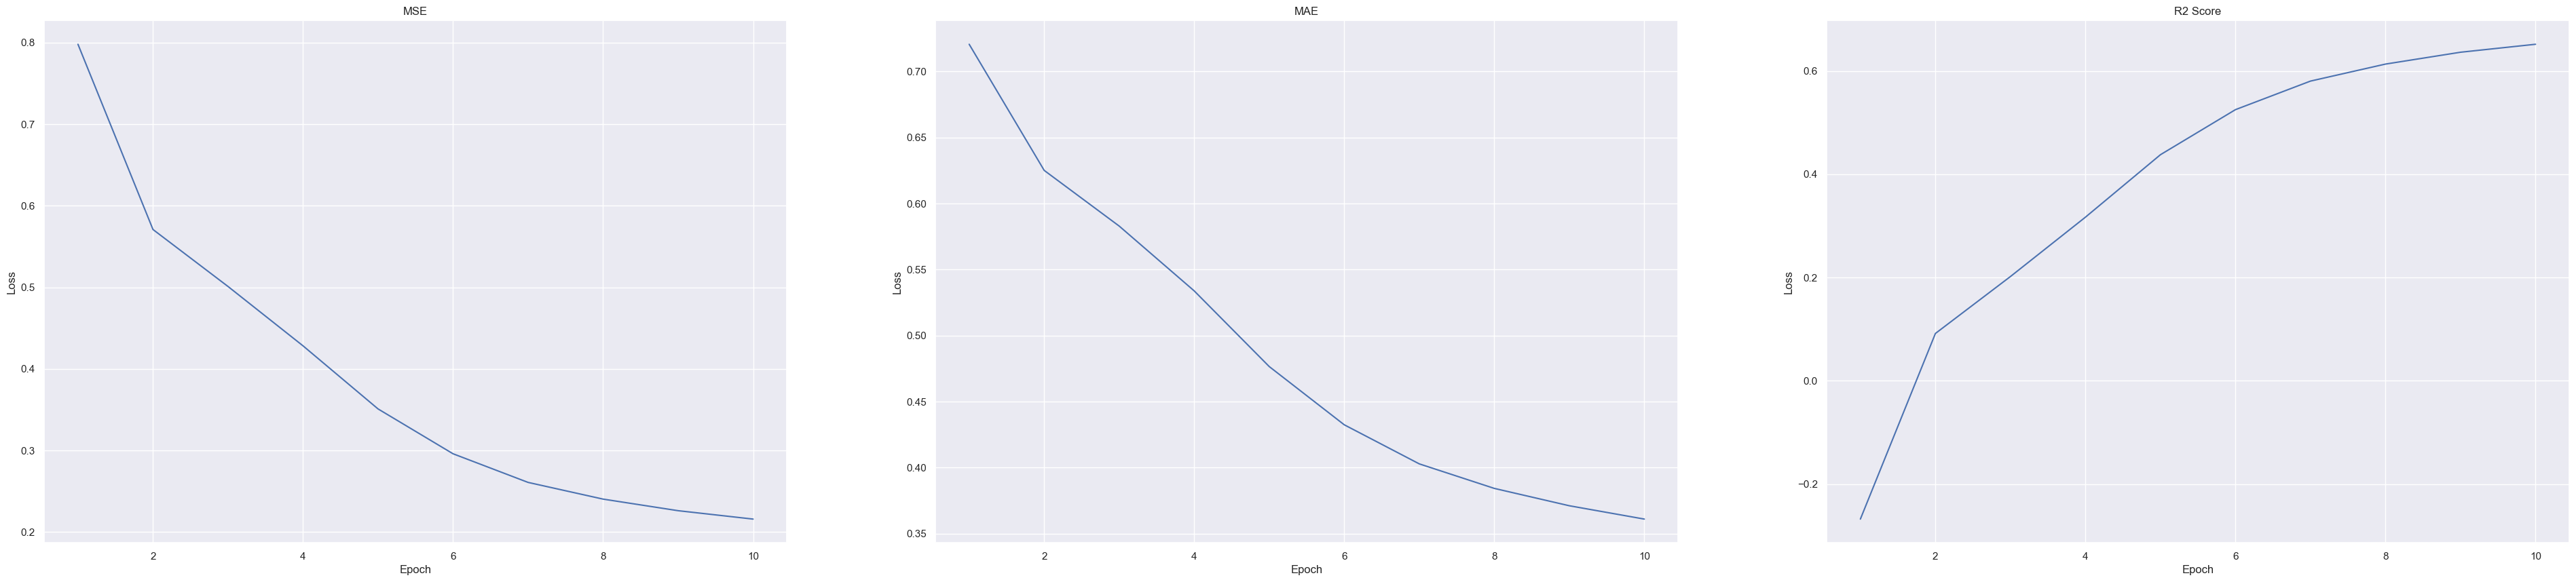

In [27]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

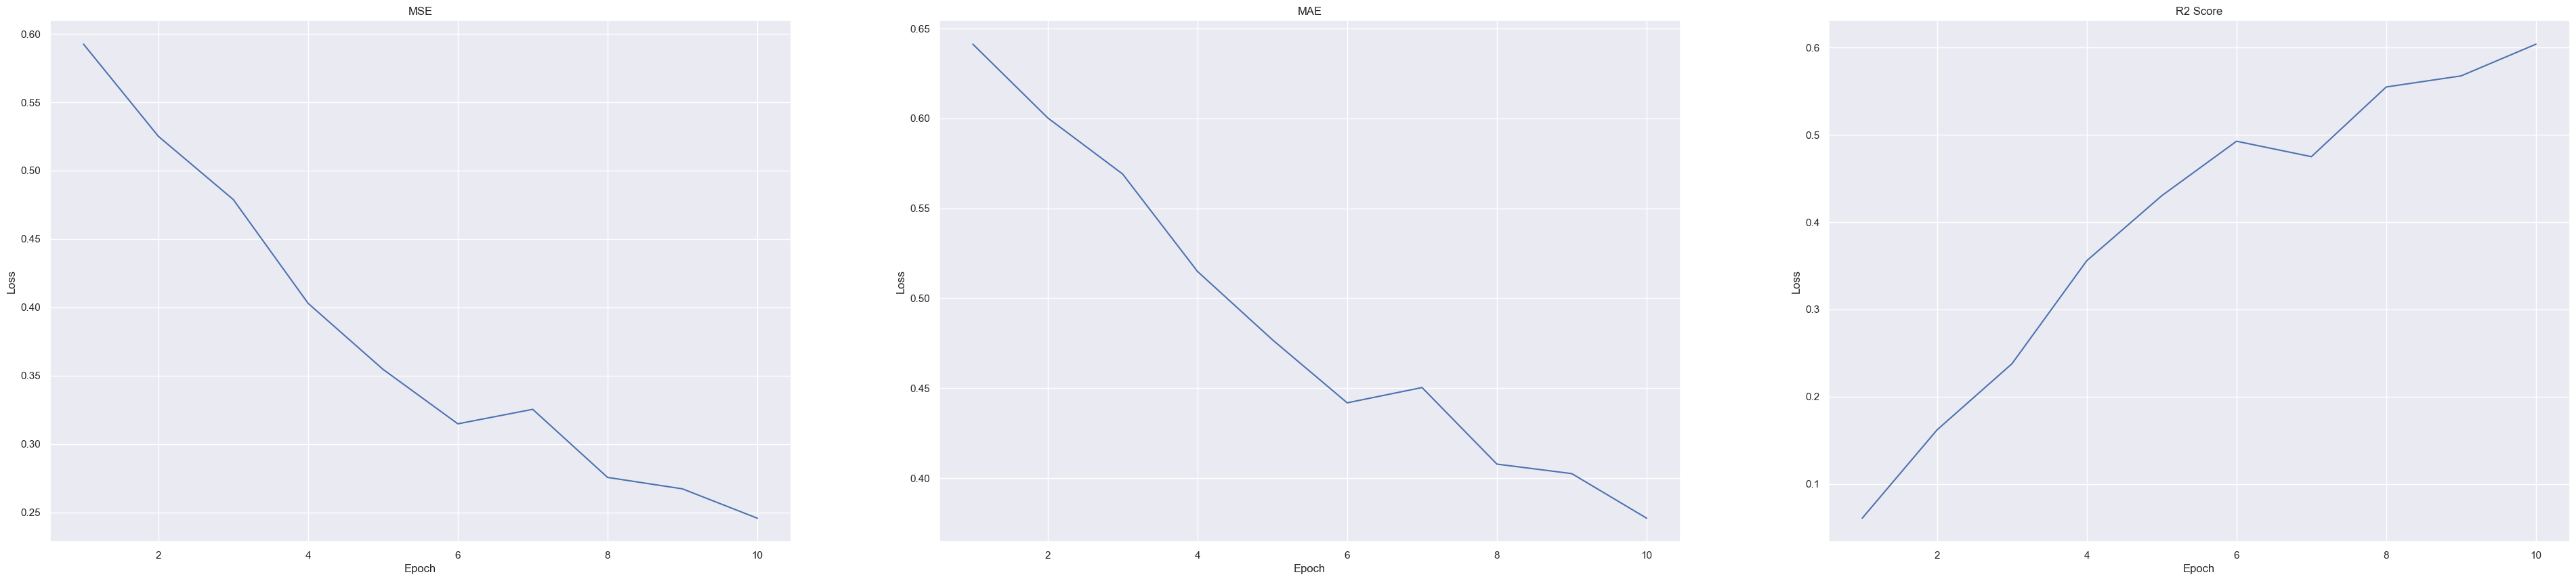

In [28]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [29]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 10
Loss  : 0.24572


<All keys matched successfully>

In [30]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = model_params
)

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.60723
MAE Loss :  0.37512
MSE Loss :  0.24223


## 5.2 Best Model

### 5.2.1 Evaluation

In [31]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 10
 Loss : 0.24572


<All keys matched successfully>

In [32]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = model_params
)

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.60564
MAE Loss :  0.37514
MSE Loss :  0.24225


### 5.2.2 Custom

In [33]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

 Key : leaf?AT1G01480.2
True : [ 0.22556]
Pred : [ 0.69387]
 MAE : [ 0.46831]
 MSE : [ 0.21931]
  R2 : [ 0.50020]

 Key : root?AT2G47240.3
True : [ 0.71603]
Pred : [ 2.23906]
 MAE : [ 1.52302]
 MSE : [ 2.31959]
  R2 : [ 0.74586]



### 5.2.3 Visualization

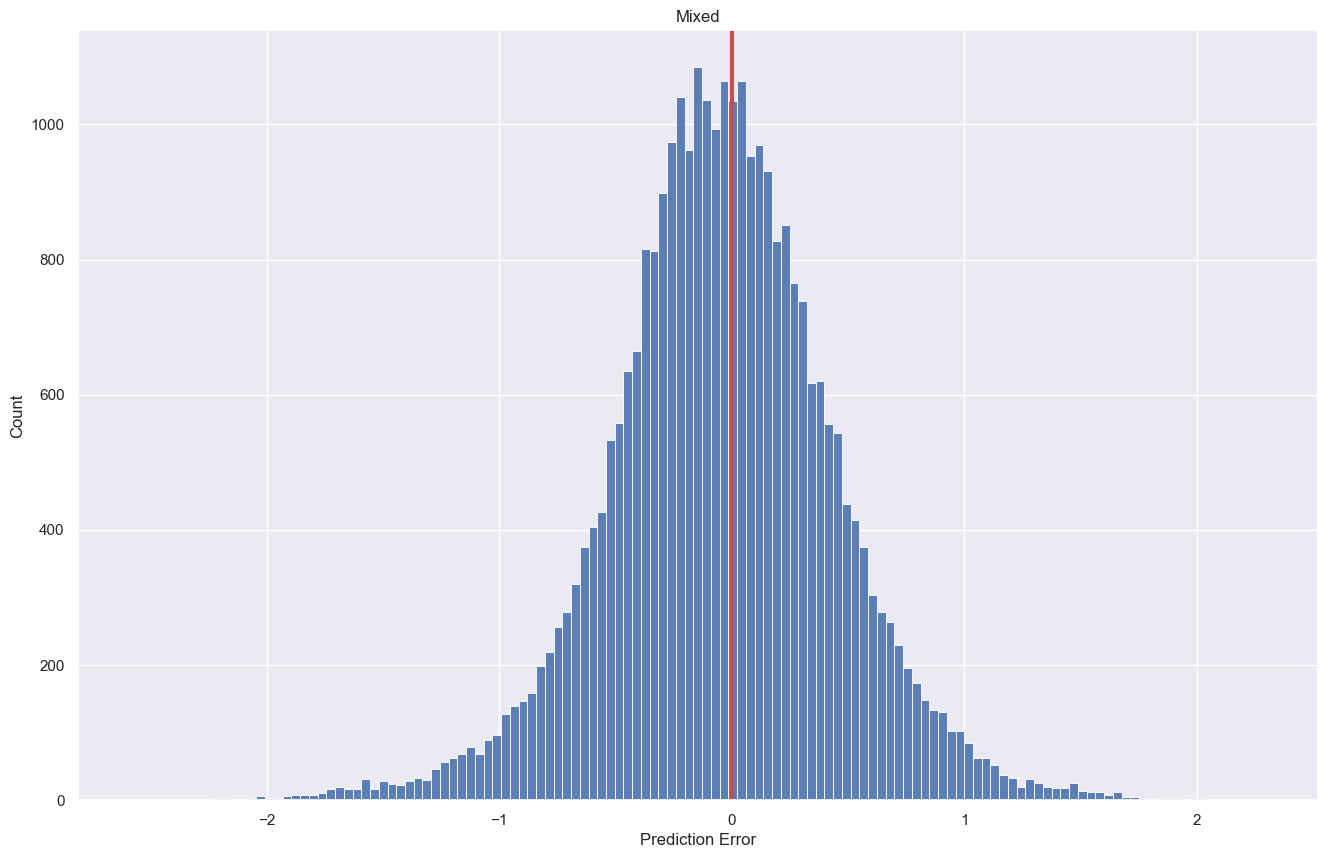

In [34]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = target_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

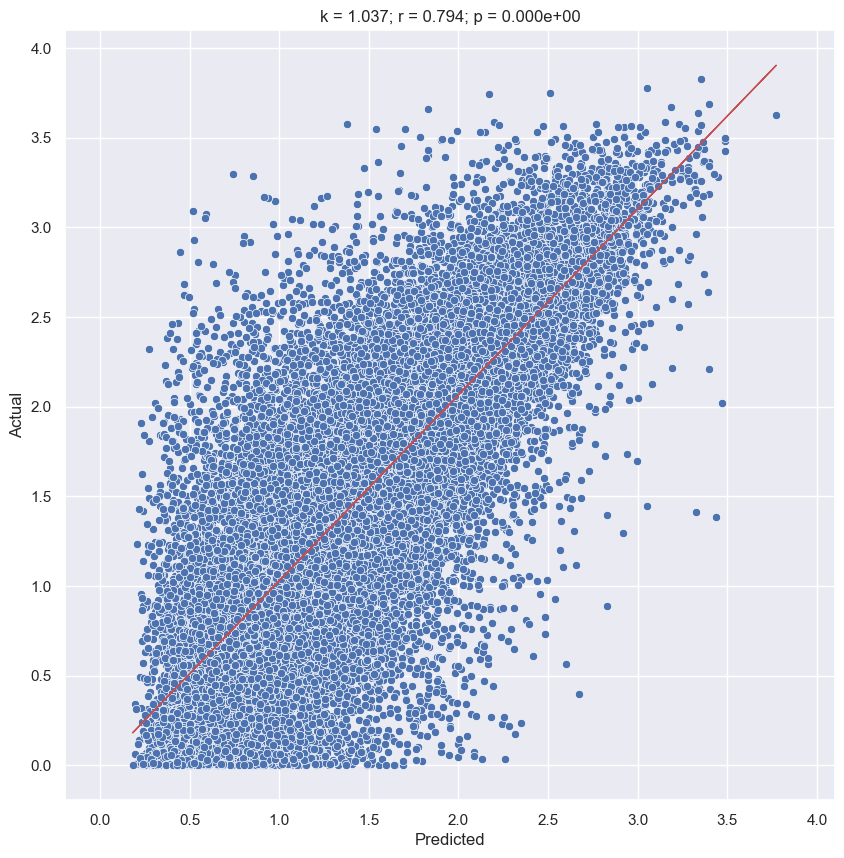

In [35]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = target_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

### 5.2.4 Mutation

In [36]:
# Evaluate the mutations

report = cnn_model.eval_regressor(
	model  = model,
	params = model_params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'mse' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse').to(DEVICE),
			'mae' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae').to(DEVICE)
		}
	}
)

print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

MAE Loss :  0.43239
MSE Loss :  0.30495


In [37]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 120
Mutations   : 6
Variants    : 20


In [38]:
# Print mutations

print(' ' + ' '.join('{:>20s}'.format(x) if i % 5 != 0 else '{:>20s}'.format(x) + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

     root?AT2G41800.1     leaf?AT3G55110.1     leaf?AT3G27530.1     seed?AT3G42860.1     leaf?AT2G41800.1
     seed?AT2G03890.2   flower?AT3G08860.2   flower?AT2G03890.2   flower?AT2G43680.4     seed?AT3G26840.1
 seedling?AT3G08860.2     root?AT5G15310.3 seedling?AT3G57420.1     seed?AT3G18524.1 seedling?AT3G26840.1
     leaf?AT2G03890.2     leaf?AT2G42760.1     leaf?AT5G62300.2     seed?AT3G22520.1   flower?AT1G55310.5
     seed?AT5G62300.2     root?AT3G22520.1     leaf?AT2G43680.4   flower?AT5G23330.1     seed?AT2G41800.1
     seed?AT1G61350.1     leaf?AT5G15310.3     seed?AT1G76440.2   flower?AT1G76440.2     leaf?AT5G05240.1
     leaf?AT1G76440.2     seed?AT3G55110.1   flower?AT2G42760.1     seed?AT2G43680.4     leaf?AT3G22520.1
     root?AT3G57420.1     root?AT2G43680.4     root?AT2G03890.2   flower?AT3G42860.1     leaf?AT1G02120.3
     leaf?AT3G26840.1     leaf?AT4G05400.1     leaf?AT3G08860.2   flower?AT5G62300.2 seedling?AT1G76660.1
 seedling?AT1G76440.2     root?AT1G55310.5    

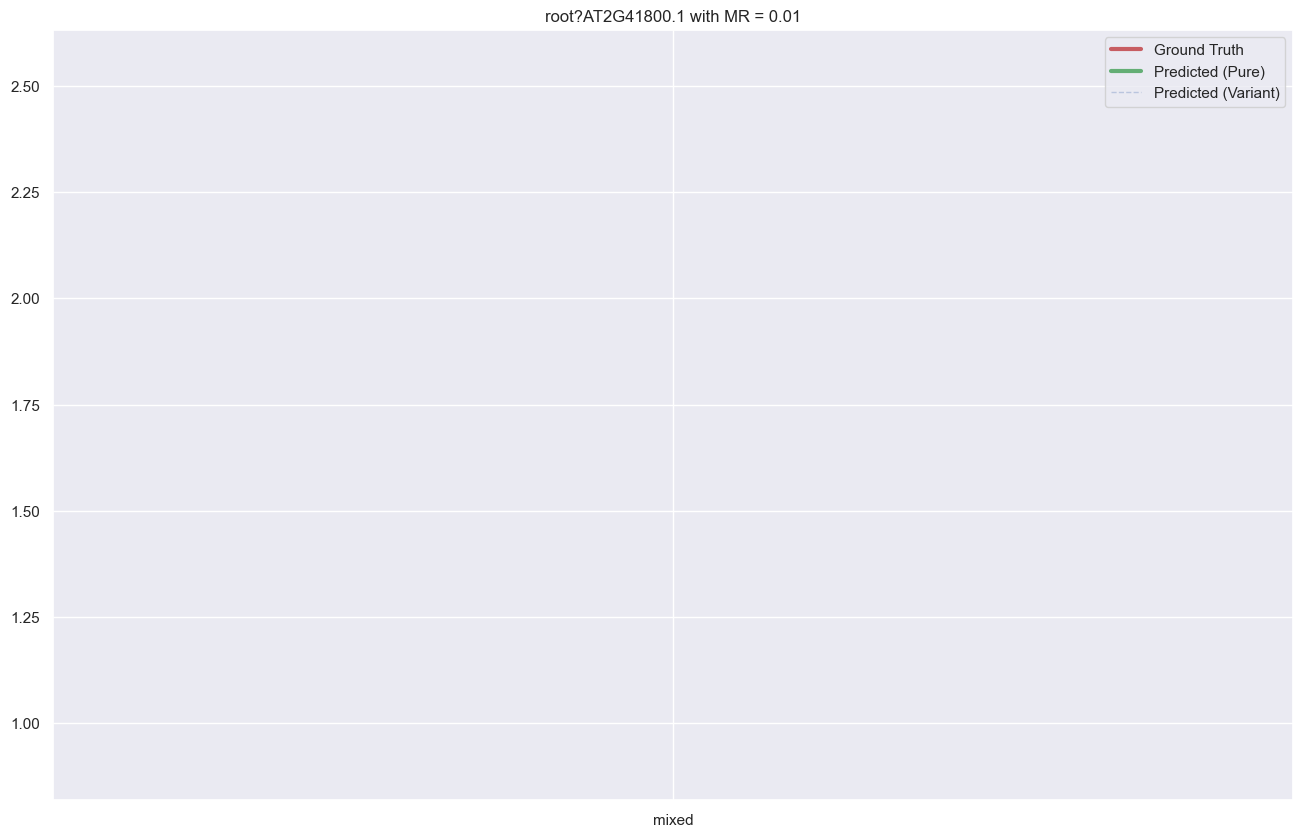

In [39]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = target_order
)

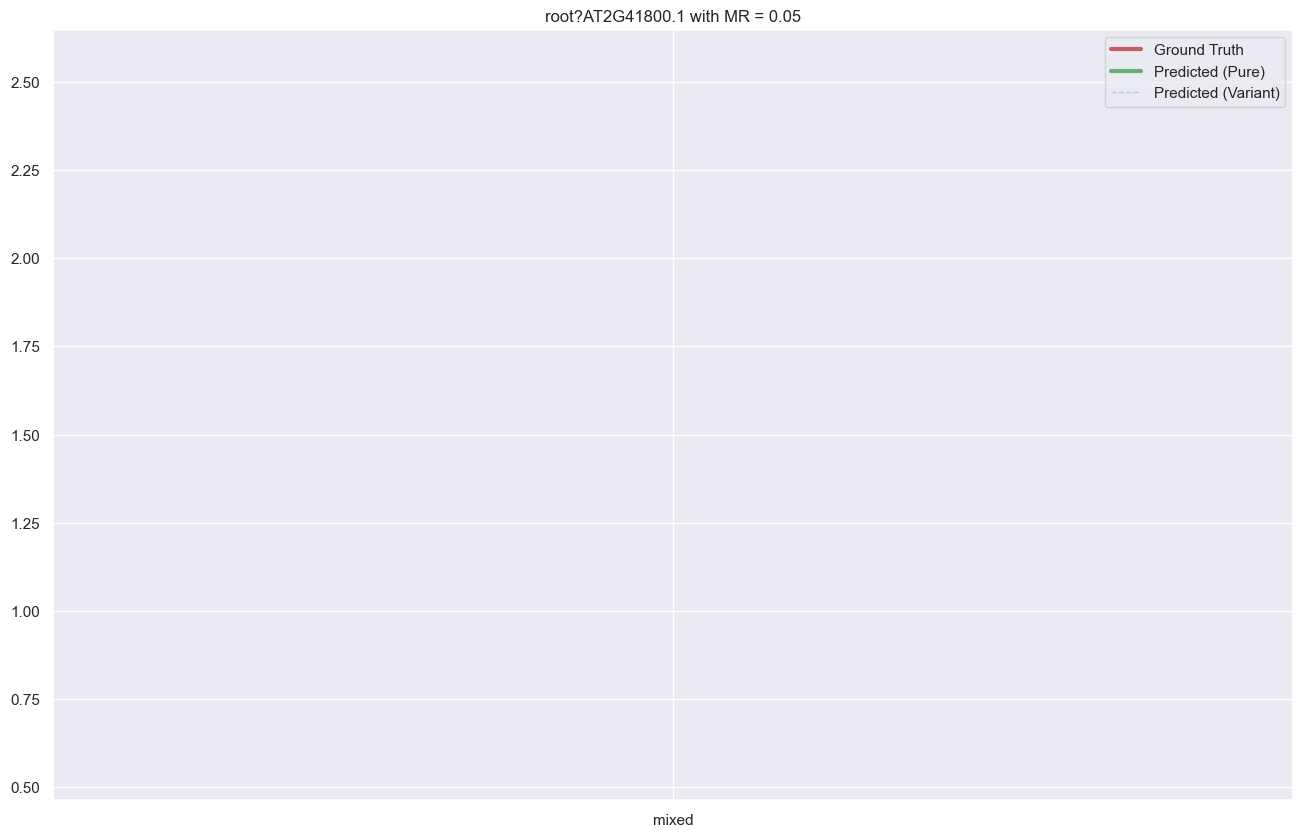

In [40]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = target_order
)

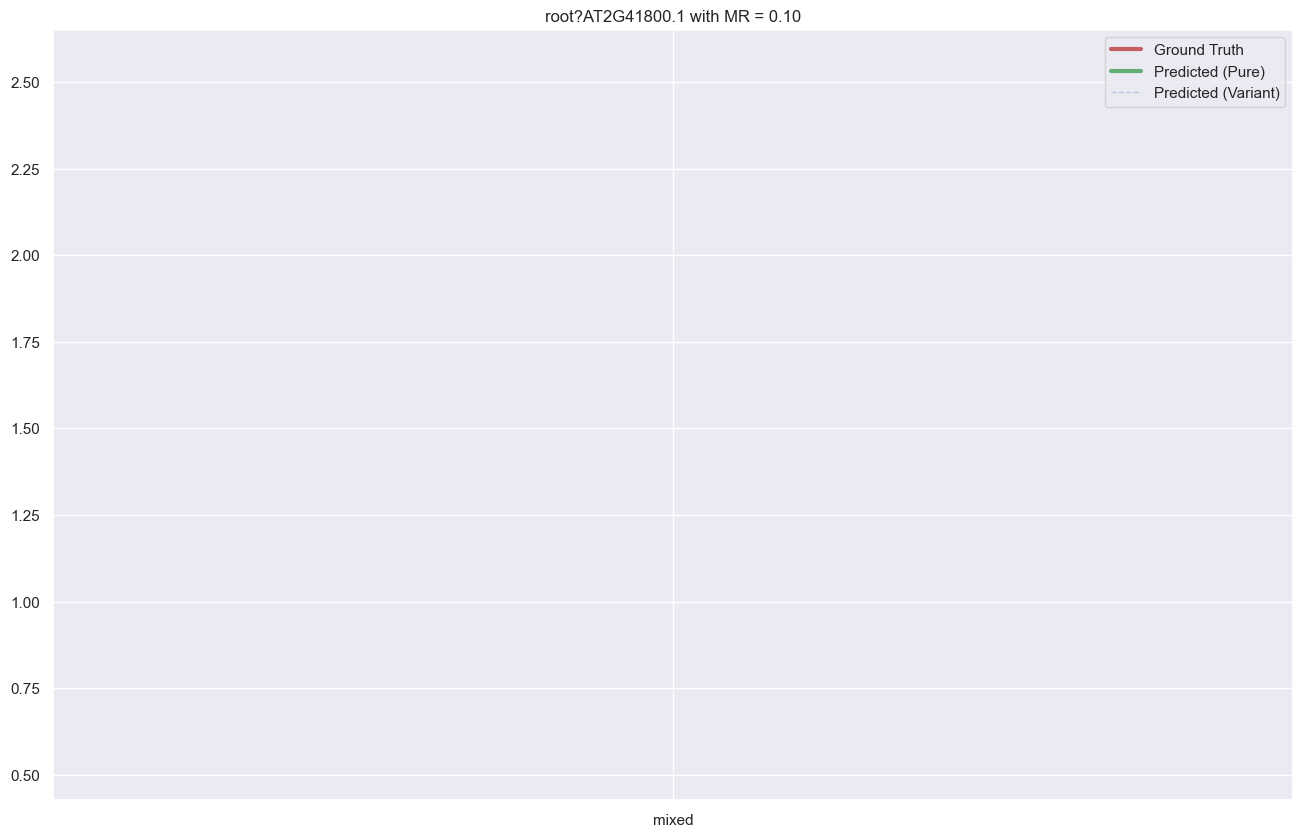

In [41]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = target_order
)